### Introduction:

#### This project attempts to identify latent structures in text data and visualize them. The dataset used consists of top 100 films of all times according to an imdb list [(Top 100 Greatest Movies of All Time (The Ultimate List) by ChrisWalczyk55)](http://www.imdb.com/list/ls055592025/)



#### Importing required libraries

In [45]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.manifold import MDS
import mpld3
import nltk
import psycopg2
import nltk
import os
import matplotlib.pyplot as plt
import matplotlib as mpl

#### Importing titles, imdb and wikipedia synopses and imdb links:

In [56]:
os.chdir("/home/pjoshi/github/data-science/projects/document-clustering")

# Titles:
titles = open('title_list.txt').read().split('\n')
titles = titles[:100]

links = open('link_list_imdb.txt').read().split('\n')
links = links[:100]

synopses_wiki = open('synopses_list_wiki.txt').read().split('\n BREAKS HERE')
synopses_wiki = synopses_wiki[:100]

# Synopses: (strip html code and convert to unicode)

synopses_clean_wiki = []
for text in synopses_wiki:
    text = BeautifulSoup(text,'html.parser').getText()
    synopses_clean_wiki.append(text)
    
synopses_wiki = synopses_clean_wiki

synopses_imdb = open('synopses_list_imdb.txt').read().split('\n BREAKS HERE')
synopses_imdb = synopses_imdb[:100]

synopses_clean_imdb = []

for text in synopses_imdb:
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean_imdb.append(text)

synopses_imdb = synopses_clean_imdb


# Genres: 

genres = open('genres_list.txt').read().split('\n')
genres = genres[:100]

print(str(len(titles)) + ' titles')
print(str(len(links)) + ' links')
print(str(len(synopses_wiki)) + ' synopses')
print(str(len(genres)) + ' genres')

100 titles
100 links
100 synopses
100 genres


#### Combining imdb and wiki synopses:

In [6]:
synopses = []

for i in range(len(synopses_wiki)):
    item = synopses_wiki[i] + synopses_imdb[i]
    synopses.append(item)

#### Generating an index for each item in corpora


In [57]:
ranks = []

for i in range(0,len(titles)):
    ranks.append(i)

### Stemming and Tokenization of Synopses



#### Import stopwords, snowball stemmer 
#### [Snowball stemmer](http://snowball.tartarus.org/) is a part of NLTK.  

In [66]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords[1:10])

# Import Snowball stemmer

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

[u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your']


#### Define functions to tokenize and stem:


In [10]:
def tokenize_and_stem(text):
    # tokenizes (splits the synopsis into a list of its respective words (or tokens) and also stems each token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]',token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # tokenizes the synopsis only
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

#### Iterate over synopses to create 2 vocabularies, one stemed and one only tokenized


In [67]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

#### Using these two lists, create a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column which can be used to to look up a stem and return a full token. 


In [68]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)


In [72]:
vocab_frame.head(10)
print()
print()
print()

### TF-IDF and Document Similarity

* Term Frequency - Inverse Document Frequency is a statistic intended to reflect how important a word is to a document in a collection or corpus.[1]

* Word occurences by documet are calulated and converted into a document-term matrix that gives the frequency of occurence of each term in each document.

* Parameters used in the TF-IDF Vectoriser are:

##### 1. max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)
##### 2. min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document.
##### 3. ngram_range: this just means I'll look at unigrams, bigrams and trigrams. See n-grams


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 10.1 s, sys: 76.6 ms, total: 10.2 s
Wall time: 10.1 s
(100, 563)


In [18]:
terms = tfidf_vectorizer.get_feature_names()
from sklearn import preprocessing, metrics, model_selection


dist is defined as 1 - cosine similarity of each document and used as a measure of similarity between each synopsis and all other synopses. Subtracting it from 1 provides cosine distance which will be used for plotting on a 2D plane.

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)


To better understand the hidden structure within the synopses, we cluster them using the tf-idf matrix. For clustering, 3 algorithms are attempted: 

1. K-Means clustering is attempted first with 5 clusters.
2. Hierarchical Clustering using Ward Algorithm
3. Latent Dirchlet Allocation

### 1. K- Means Clustering

In [21]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters = num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()


CPU times: user 481 ms, sys: 0 ns, total: 481 ms
Wall time: 478 ms


Using joblib.dump() to pickle the model, once it has converged and reload the model/reassign labels as clusters.

In [34]:
from sklearn.externals import joblib

joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

Creating a dictionary of titles, ranks, the synopsis, the cluster assignment, and the genre and converting to a Pandas DataFrame:

In [73]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [76]:
# check number of films per cluster
frame['cluster'].value_counts()

4    26
0    25
2    21
1    16
3    12
Name: cluster, dtype: int64

In [80]:
grouped = frame['rank'].groupby(frame['cluster'])

grouped.mean()


cluster
0    47.200000
1    58.875000
2    49.380952
3    54.500000
4    43.730769
Name: rank, dtype: float64

Indexing and sorting on each cluster to identify which are the top n words that are nearest to the cluster centroid to give a good sense of the main topic of the cluster.

In [41]:
from __future__ import print_function

print("Top terms per cluster:")
print()

order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()


Top terms per cluster:

Cluster 0 words: family, home, mother, war, house, dies,

Cluster 0 titles: Schindler's List, One Flew Over the Cuckoo's Nest, Gone with the Wind, The Wizard of Oz, Titanic, Forrest Gump, E.T. the Extra-Terrestrial, The Silence of the Lambs, Gandhi, A Streetcar Named Desire, The Best Years of Our Lives, My Fair Lady, Ben-Hur, Doctor Zhivago, The Pianist, The Exorcist, Out of Africa, Good Will Hunting, Terms of Endearment, Giant, The Grapes of Wrath, Close Encounters of the Third Kind, The Graduate, Stagecoach, Wuthering Heights,

Cluster 1 words: police, car, killed, murders, driving, house,

Cluster 1 titles: Casablanca, Psycho, Sunset Blvd., Vertigo, Chinatown, Amadeus, High Noon, The French Connection, Fargo, Pulp Fiction, The Maltese Falcon, A Clockwork Orange, Double Indemnity, Rebel Without a Cause, The Third Man, North by Northwest,

Cluster 2 words: father, new, york, new, brothers, apartments,

Cluster 2 titles: The Godfather, Raging Bull, Citizen Kane,

In [42]:
#This is purely to help export tables to html and to correct for my 0 start rank (so that Godfather is 1, not 0)
frame['Rank'] = frame['rank'] + 1
frame['Title'] = frame['title']

In [ ]:
#export tables to HTML
print(frame[['Rank', 'Title']].loc[frame['cluster'] == 1].to_html(index=False))

## Multidimensional Scaling:

Using MDS we convert the DTM into a 2D array for visualizing the clusters

In [47]:
MDS()

MDS(dissimilarity='euclidean', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=1, random_state=None, verbose=0)

In [48]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

## Visualizing document clusters

In [49]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}

In [50]:
%matplotlib inline


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


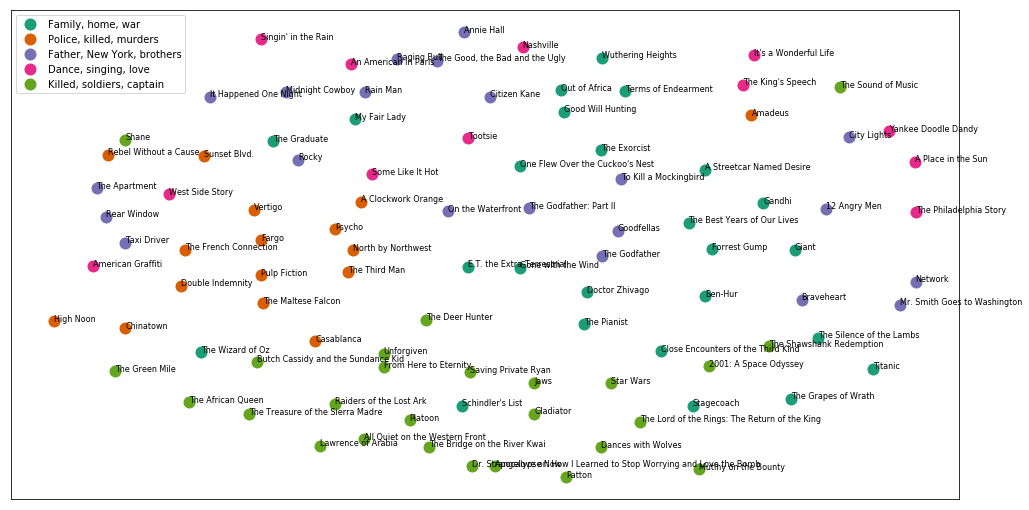

In [81]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [53]:
plt.close()


### 2. Hierarchical document clustering

Ward clustering is an agglomerative clustering method, meaning that at each stage, the pair of clusters with minimum between-cluster distance are merged. 

The precomputed cosine distance matrix (dist) is used to calclate a linkage_matrix, which I then plot as a dendrogram.

This method returned 3 primary clusters, with the largest cluster being split into about 4 major subclusters. 

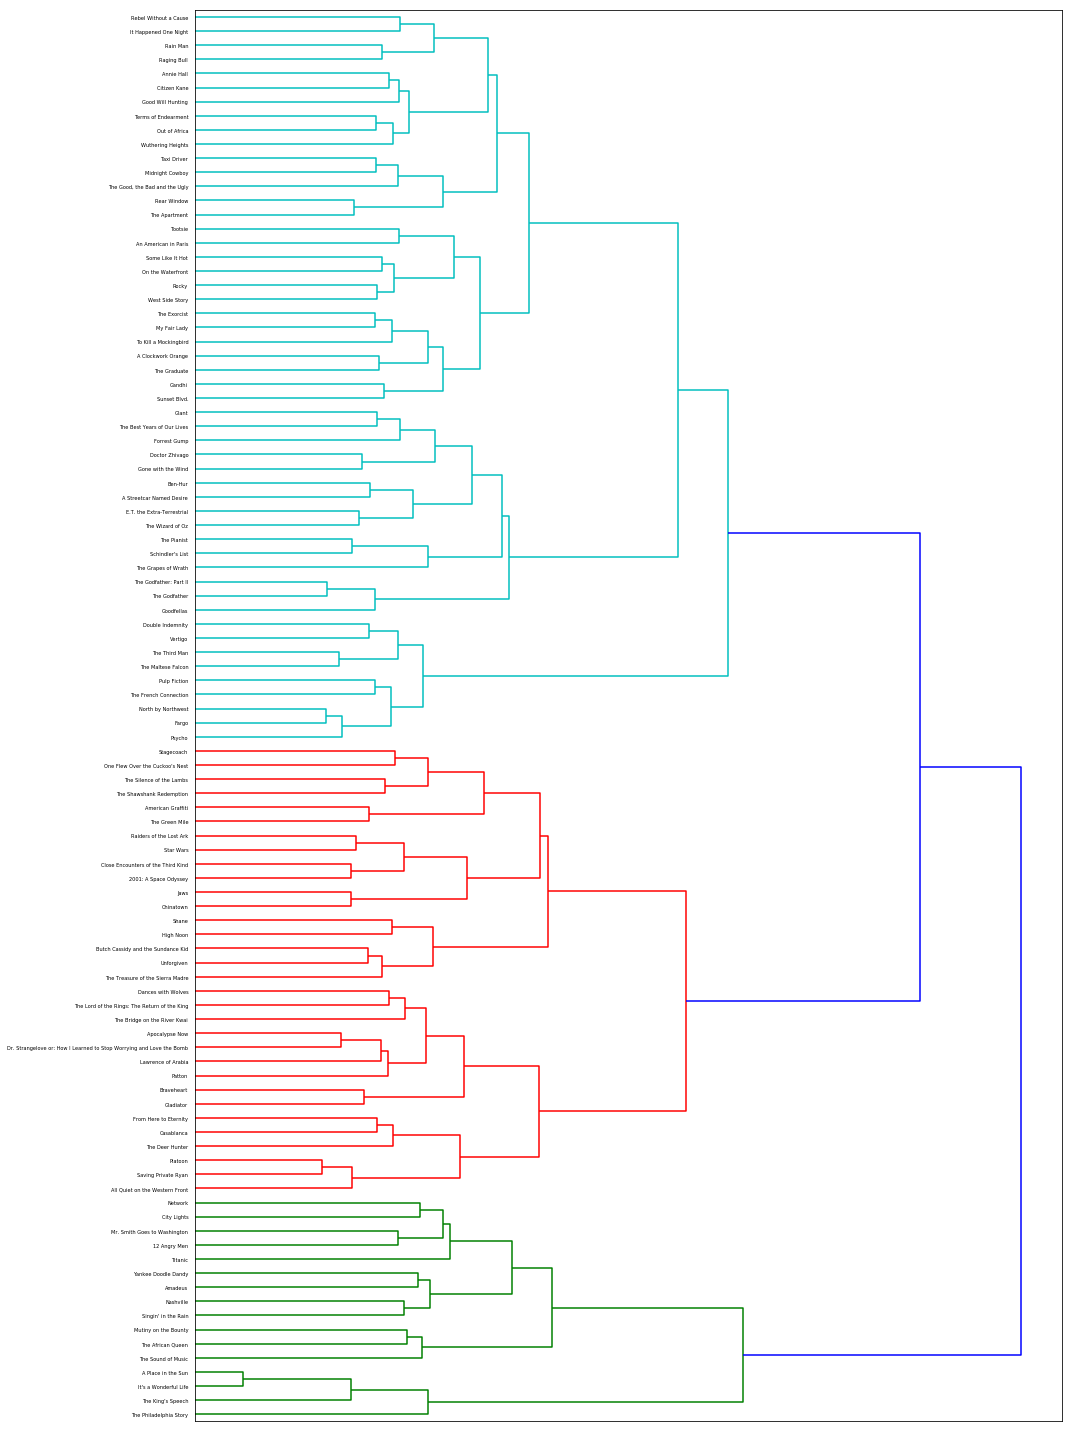

In [87]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize = (15,20)) #set size
x = dendrogram(linkage_matrix, orientation = "right", labels = titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters



In [88]:
plt.close()

### 3. Latent Dirichlet Allocation

Latent Dirichlet Allocation (LDA) is a probabilistic topic model that assumes documents are a mixture of topics and that each word in the document is attributable to the document's topics. 


In [93]:
#function to removing any proper names from a text
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

# removing stop words, proper nouns and tokenization
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in synopses]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]


ImportError: No module named gensim

In [94]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

ImportError: No module named gensim

In [95]:
len(corpus)

%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

print(lda[corpus[0]])

topics = lda.print_topics(5, num_words=20)

topics_matrix = lda.show_topics(formatted=False, num_words=20)

topics_matrix = np.array(topics_matrix)

topics_matrix.shape

topic_words = topics_matrix[:,:,1]

for i in topic_words:
    print([str(word) for word in i])
    print()

NameError: name 'corpus' is not defined

In [127]:
#### Word2vec


In [161]:
synopses_df = pd.DataFrame.merge(pd.DataFrame(titles), pd.DataFrame(synopses),left_index = True, right_index = True)

In [163]:
print(synopses_df)

                                                  0_x  \
0                                       The Godfather   
1                            The Shawshank Redemption   
2                                    Schindler's List   
3                                         Raging Bull   
4                                          Casablanca   
5                     One Flew Over the Cuckoo's Nest   
6                                  Gone with the Wind   
7                                        Citizen Kane   
8                                    The Wizard of Oz   
9                                             Titanic   
10                                 Lawrence of Arabia   
11                             The Godfather: Part II   
12                                             Psycho   
13                                       Sunset Blvd.   
14                                            Vertigo   
15                                  On the Waterfront   
16                             

#### References:
[1] https://en.wikipedia.org/wiki/Tf%E2%80%93idf